Make sure to spin up your Neo4j database first!

```
docker run \
    -p 7474:7474 -p 7687:7687 \
    -v $PWD/data:/data -v $PWD/plugins:/plugins \
    --name neo4j-apoc \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    -e NEO4JLABS_PLUGINS=\[\"apoc\"\] \
    neo4j:latest
```

## Connect with Neo4j

In [1]:
import os

from langchain_neo4j import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "llamaindex"

graph = Neo4jGraph(refresh_schema=False)

## Setup LLM

In [5]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen2.5", temperature=0)

In [7]:
llm_transformer = LLMGraphTransformer(llm=llm)

## Read PDF

In [12]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path="../docs/MBA_Worth_It.pdf")
docs = []
async for page in loader.alazy_load():
    docs.append(page)

## Construct graph!

In [14]:
graph_documents = llm_transformer.convert_to_graph_documents(docs)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Mba Degree', type='Degree', properties={}), Node(id='Business Education', type='Education', properties={}), Node(id='Aaron Amat / Getty Images', type='Image', properties={}), Node(id='Liza Kirkpatrick', type='Person', properties={})]
Relationships:[Relationship(source=Node(id='Mba Degree', type='Degree', properties={}), target=Node(id='Business Education', type='Education', properties={}), type='IS_A', properties={}), Relationship(source=Node(id='Liza Kirkpatrick', type='Person', properties={}), target=Node(id='Mba Degree', type='Degree', properties={}), type='WRITTEN_BY', properties={})]


## Ingest graph into Neo4j!

In [15]:
graph.add_graph_documents(graph_documents)

Check out our nice graph!

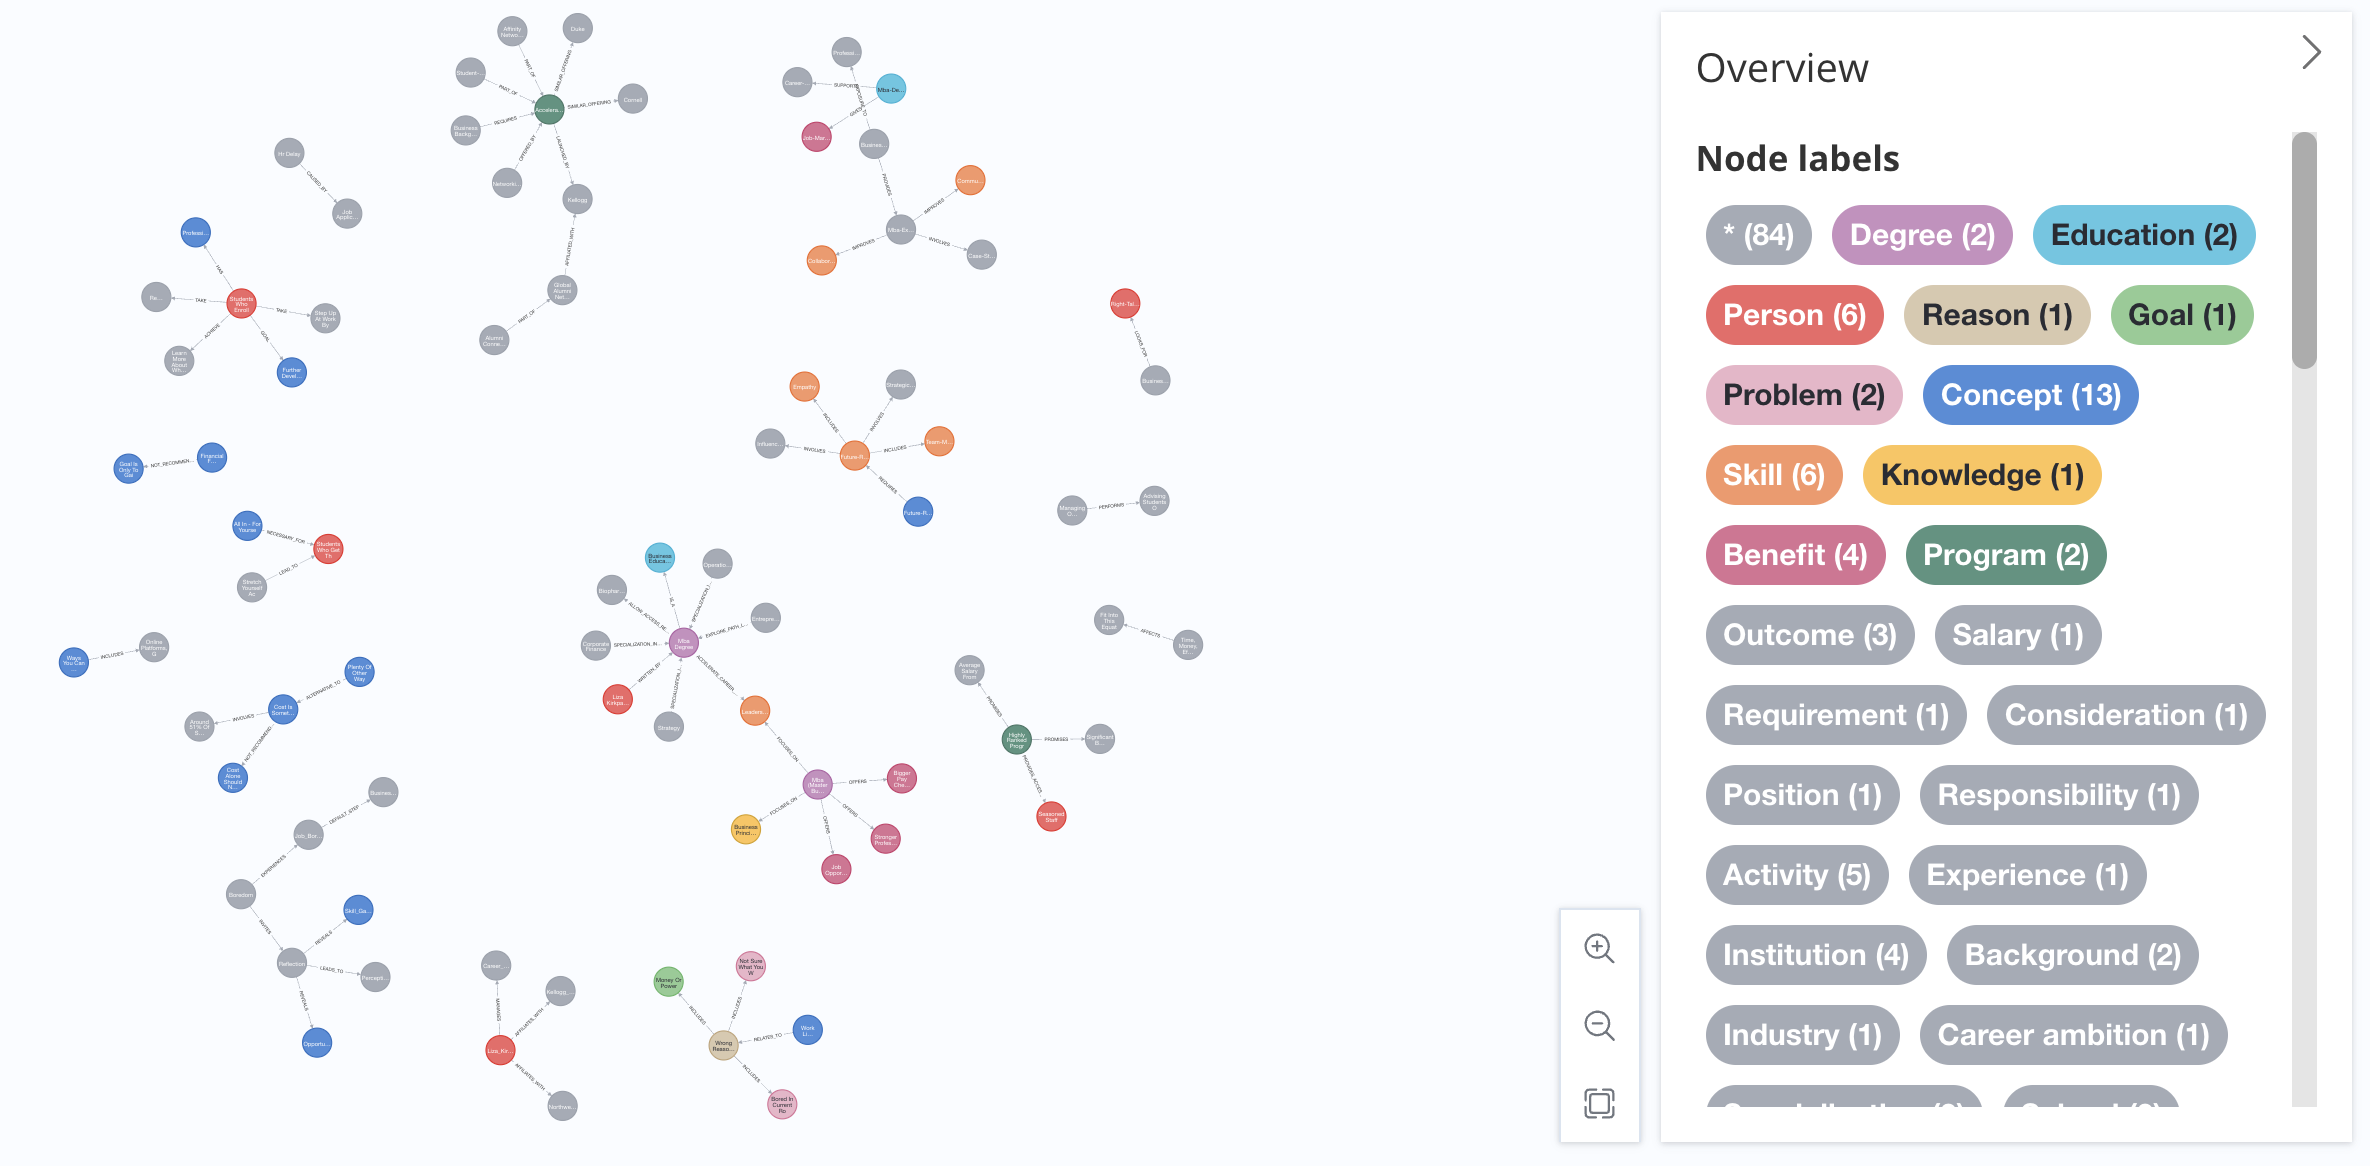

In [16]:
from IPython.display import Image

Image(filename="../images/FullGraph.png")

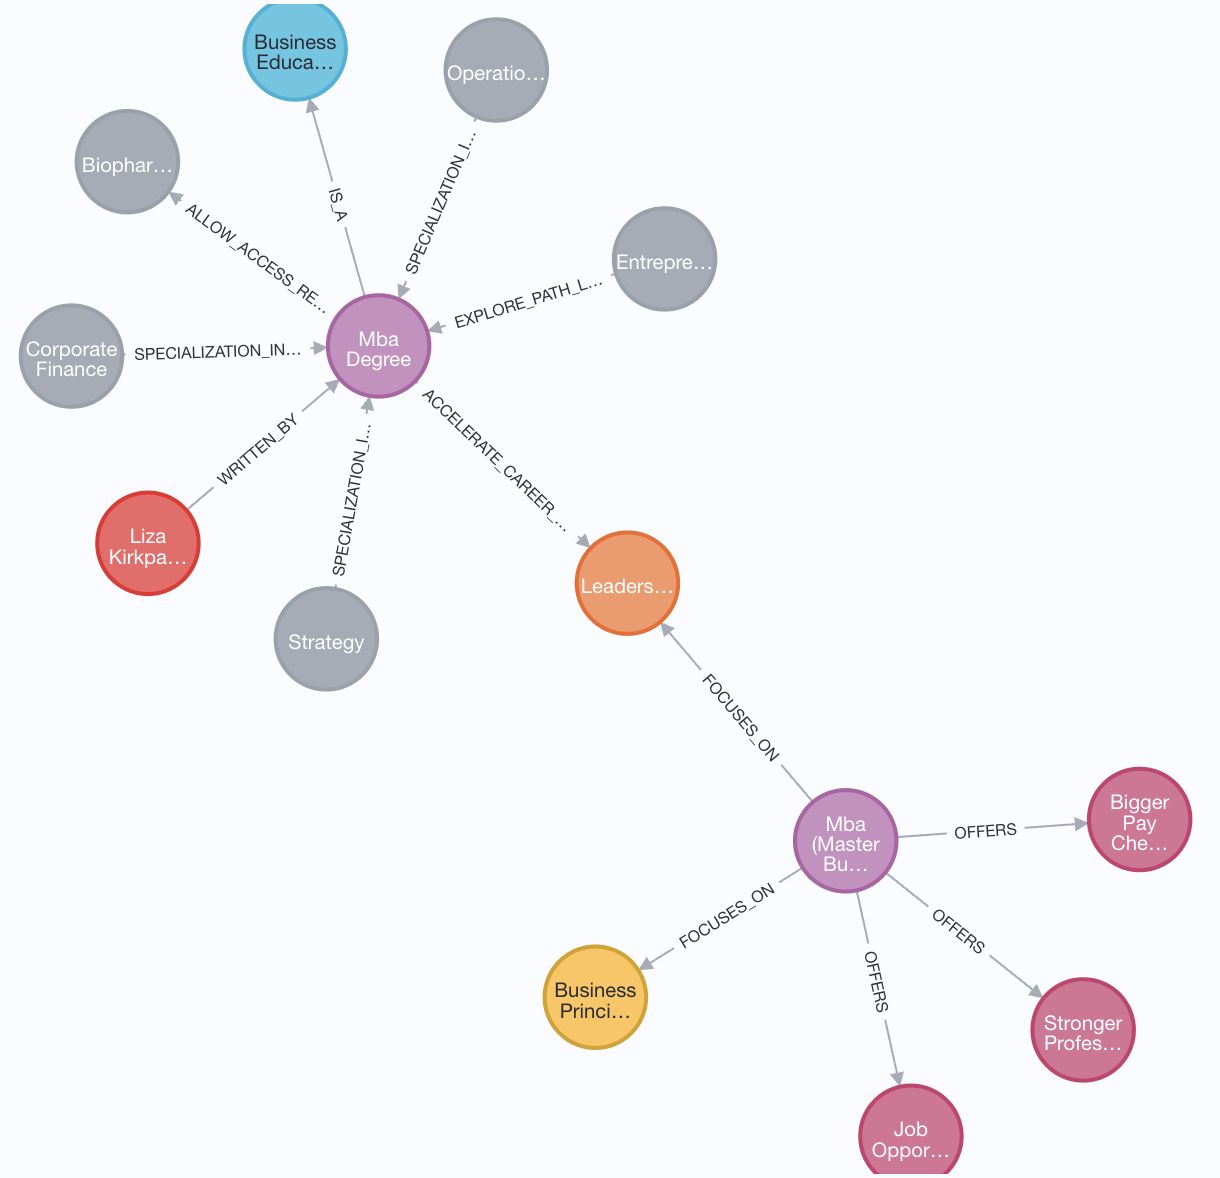

In [17]:
Image(filename="../images/ZoomIn.png")

## Query!

In [33]:
from langchain_neo4j import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(
    llm, 
    graph=graph, 
    verbose=True, 
    return_intermediate_steps=True,
    allow_dangerous_requests=True
)

In [37]:
response = chain.invoke(
    {"query": "What are the wrong reasons to get an MBA?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (r:Reason)-[:WRONG_REASON]->(m:MBA)
RETURN r.reason
Full Context:
[]

> Finished chain.


In [38]:
from IPython.display import display, Markdown
display(Markdown(response['result']))

I don't have specific information on wrong reasons to get an MBA from the provided data. However, some common incorrect motivations might include pursuing an MBA for the sake of prestige or because friends or family think it's a good idea without considering personal career goals and interests.

In [39]:
response['intermediate_steps']

[{'query': 'MATCH (r:Reason)-[:WRONG_REASON]->(m:MBA)\nRETURN r.reason'},
 {'context': []}]

In [43]:
response = chain.invoke(
    {"query": "Does an MBA's ranking matter"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (m:Person {degreeType:'MBA'})-[:HAS_RANKING]->(r:Ranking)
RETURN r.matter

Full Context:
[]

> Finished chain.


In [44]:
display(Markdown(response['result']))

The importance of an MBA's ranking can vary depending on the individual's career goals and the specific program. Higher-ranked programs may offer better networking opportunities and access to top-tier companies, but it is not the only factor that matters in a successful career.